## Variational AutoEncoder (VAE)

Paper: [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114)

Helpful resources:
- [Datacamp's tutorial on VAE](https://www.datacamp.com/tutorial/variational-autoencoders)
- [CodeEmporium's video on VAE](https://youtu.be/fcvYpzHmhvA?si=WBQ9X6yVhKPOVagA)
- [Stanford's Deep Generative Models playlist](https://youtube.com/playlist?list=PLoROMvodv4rPOWA-omMM6STXaWW4FvJT8&si=N_TpTe1bPIhte-t8)
- ExplainingAI's videos on VAE:
    - [Understanding VAE](https://youtu.be/1RPdu_5FCfk?si=ku_-AMmJI991t0To)
    - [Implementing VAE](https://youtu.be/pEsC0Vcjc7c?si=u3mBvhTaJ77a-mnP)
- Kapil Sachdeva's playlist on [Variational inference and autoencoder](https://youtube.com/playlist?list=PLivJwLo9VCUK1dXFU9Ig96fjANOMdoL9R&si=1ZIUhygpnF8l8SxY)
- [AI Summer's blog on VAE](https://theaisummer.com/latent-variable-models/)

Check my Kaggle notebook for the results = https://www.kaggle.com/code/aryamanbansal/variational-autoencoder

Also, it does automatic mixed precision training with VAE!

In [30]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch import GradScaler, autocast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math

import os
from tqdm import tqdm
from datetime import datetime
import pytz
import copy
import time
import gc

print("imports done!")

imports done!


In [31]:
def get_torch_version():
    torch_version = torch.__version__.split("+")[0]
    torch_number = torch_version.split(".")[:2]
    torch_number_float = torch_number[0] + "." + torch_number[1]
    torch_number_float = float(torch_number_float)
    return torch_number_float


def set_seed(seed=42):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        # if get_torch_version() <= 1.7:
        #     torch.set_deterministic(True)
        # else:
        #     torch.use_deterministic_algorithms(True)
    print(f"seed {seed} set!")
    

def set_scheduler(scheduler, results, scheduler_on):
    """Makes the neccessary updates to the scheduler."""
    if scheduler_on == "valid_acc":
        scheduler.step(results["valid_acc"][-1])
    elif scheduler_on == "valid_loss":
        scheduler.step(results["valid_loss"][-1])
    elif scheduler_on == "train_acc":
        scheduler.step(results["train_acc"][-1])
    elif scheduler_on == "train_loss":
        scheduler.step(results["train_loss"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def visualize_results(results, plot_name=None):
    """Plot the training and validation loss and accuracy, given the results dictionary"""
    train_loss, train_acc = results["train_loss"], results["train_acc"]
    val_loss, val_acc = results["valid_loss"], results["valid_acc"]
    cls = ["no", "vort", "sphere"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    # ax[0,0].set_title("Loss")
    ax[0,0].set_xlabel("Epochs")
    ax[0,0].set_ylabel("Loss")
    ax[0,0].plot(x, train_loss, label="train_loss", color="orange")
    ax[0,0].plot(x, val_loss, label="valid_loss", color="blue")
    ax[0,0].legend()
    # ax[0,1].set_title("Accuracy")
    ax[0,1].set_xlabel("Epochs")
    ax[0,1].set_ylabel("Accuracy")
    ax[0,1].plot(x, train_acc, label="train_acc", color="orange")
    ax[0,1].plot(x, val_acc, label="valid_acc", color="blue")
    ax[0,1].legend()
    # ax[1,0].set_title("Train ROC AUC Plot")
    ax[1,0].set_xlabel("Epochs")
    ax[1,0].set_ylabel("Train ROC AUC Score")
    ax[1,0].plot(x, results["train_roc_auc_0"], label=cls[0])
    ax[1,0].plot(x, results["train_roc_auc_1"], label=cls[1])
    ax[1,0].plot(x, results["train_roc_auc_2"], label=cls[2])
    ax[1,0].legend()
    # ax[1,1].set_title("Valid ROC AUC Plot")
    ax[1,1].set_xlabel("Epochs")
    ax[1,1].set_ylabel("Valid ROC AUC Score")
    ax[1,1].plot(x, results["valid_roc_auc_0"], label=cls[0])
    ax[1,1].plot(x, results["valid_roc_auc_1"], label=cls[1])
    ax[1,1].plot(x, results["valid_roc_auc_2"], label=cls[2])
    ax[1,1].legend()
    if plot_name is not None:
        plt.savefig(plot_name)
    plt.show()


def save_model_info(path: str, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.to(device)
    torch.save(model.state_dict(), os.path.join(path,model_name))
    torch.save(optimizer.state_dict(), os.path.join(path,optimizer_name))
    if scheduler is not None:
        torch.save(scheduler.state_dict(), os.path.join(path,scheduler_name))    
    print("Model info saved!")
    
    
def load_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.load_state_dict(torch.load(os.path.join(path,model_name)))
    model.to(device)
    optimizer.load_state_dict(torch.load(os.path.join(path,optimizer_name)))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(os.path.join(path,scheduler_name)))
    print("Model info loaded!")
    
    
def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


print("Utility functions created!")

Utility functions created!


In [32]:
get_torch_version()

2.5

In [33]:
set_seed(42)

seed 42 set!


In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### **Problems with a simple autoencoder**

- Sampled images might not be valid (or realistic):
    - Simple autoencoders will try to push away the training points in the latent space as far apart as possible. This is because the loss function of the autoencoder is based on the reconstruction error, and the model will try to minimize this error by pushing the points away from each other.
    - When we sample a point from the latent space, it might not be a valid point, and the decoder might not be able to generate a realistic image from it.
- New variations of the data are not possible:
    - Since we don't know the distribution of the data in the latent space, we can't sample new points from it. We can only sample the points that are present in the training set.
    - So, a simple autoencoder memorizes the *mapping* of the training data to the latent space, but it doesn't learn the *distribution* of the data in the latent space. 

#### **How does a Variational Autoencoder (VAE) solve these problems?**

- **VAE learns the distribution of the data in the latent space**:
    - VAE assumes that the data in the latent space follows a Gaussian distribution. This assumption allows us to sample new points from the latent space. So, instead of returning a single point only, the encoder now returns the mean $\mu$ and the log of variance $\text{log}(\sigma^2)$ of the distribution of that point. 
- **VAE generates new data points**:
    - Since we know the distribution of the data in the latent space, we can sample new points from it and generate new data points using the decoder.
- **VAE generates realistic images**:
    - The decoder of the VAE is trained to generate realistic images from the points sampled from the latent space. This is because the loss function of the VAE is based on the reconstruction error and the KL divergence between the distribution of the data in the latent space and the Gaussian distribution.

<figure>
  <div style="display: flex; justify-content: center; gap: 2rem;">
    <div style="text-align: center;">
      <img
        src="https://media.datacamp.com/cms/google/ad_4nxcqhvplhhjejvesie9iz9uurrlrzs3z5czb1pyo0kdq6ydkq-1votcagezdamobl7to7k4rlazhf9hcjcnbleocqytyrc4rjv65zxujw2vha6fjpmi3tvzxhchensesn2q6kgnlj1hcpdnbutpjg0rxru0.png" width="600"
        alt="Simple Autoencoder architecture"
      />
      <p style="text-align: center;"><strong>Simple Autoencoder architecture</strong></p>
    </div>
    <div style="text-align: center;">
      <img
        src="https://media.datacamp.com/cms/google/ad_4nxdmkiee_ttomnlm7hbv3hfw8pi5u9_hcoj_n8dvdnarca2ljdmh8nwvm4icp4vt1kieguzhmzosaqh3vul3ysb14_yuht8ero0wxwnd1ctv9ghlkmzpy8z5mhbi4ve4342i-_cks5gumhjt64ybkpbz0l-o.png" width="720"
        alt="Variational Autoencoder architecture"
      />
      <p style="text-align: center;"><strong>Variational Autoencoder architecture</strong></p>
    </div>
  </div>
  <figcaption style="text-align: center; margin-top: 1rem;">
    <strong>Source:</strong> <a href="https://www.datacamp.com/tutorial/variational-autoencoders">Datacamp</a>
  </figcaption>
</figure>


Workflow of VAE for a single input datapoint $x$:
1. Send input point $x$ to the encoder.
2. The encoder returns the parameters (mean $\mu$ and log of variance $\text{log}(\sigma^2)$) of the distribution of the point $x$, instead of the point itself.
3. By reparameterization trick, calculate: $z = \mu + \sigma \cdot \varepsilon$, where $\varepsilon \in \mathcal{N}(0,1)$.
4. Send $z$ to the decoder to get a generated data point.
5. Calculate ELBO by using $x, z, \mu, \text{log}(\sigma^2)$.

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     transforms.Resize((32, 32))
    ])

batch_size = 128

train_dataset = torchvision.datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = torchvision.datasets.FashionMNIST(root='./', train=False, download=True, transform=transform)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [36]:
print("length of train_dataset:", len(train_dataset))
print("length of valid_dataset:", len(valid_dataset))

length of train_dataset: 60000
length of valid_dataset: 10000


In [37]:
print(len(train_dataset[0]))
print("input shape:\t", train_dataset[0][0].shape)
print("label:\t\t", train_dataset[0][1])

2
input shape:	 torch.Size([1, 32, 32])
label:		 9


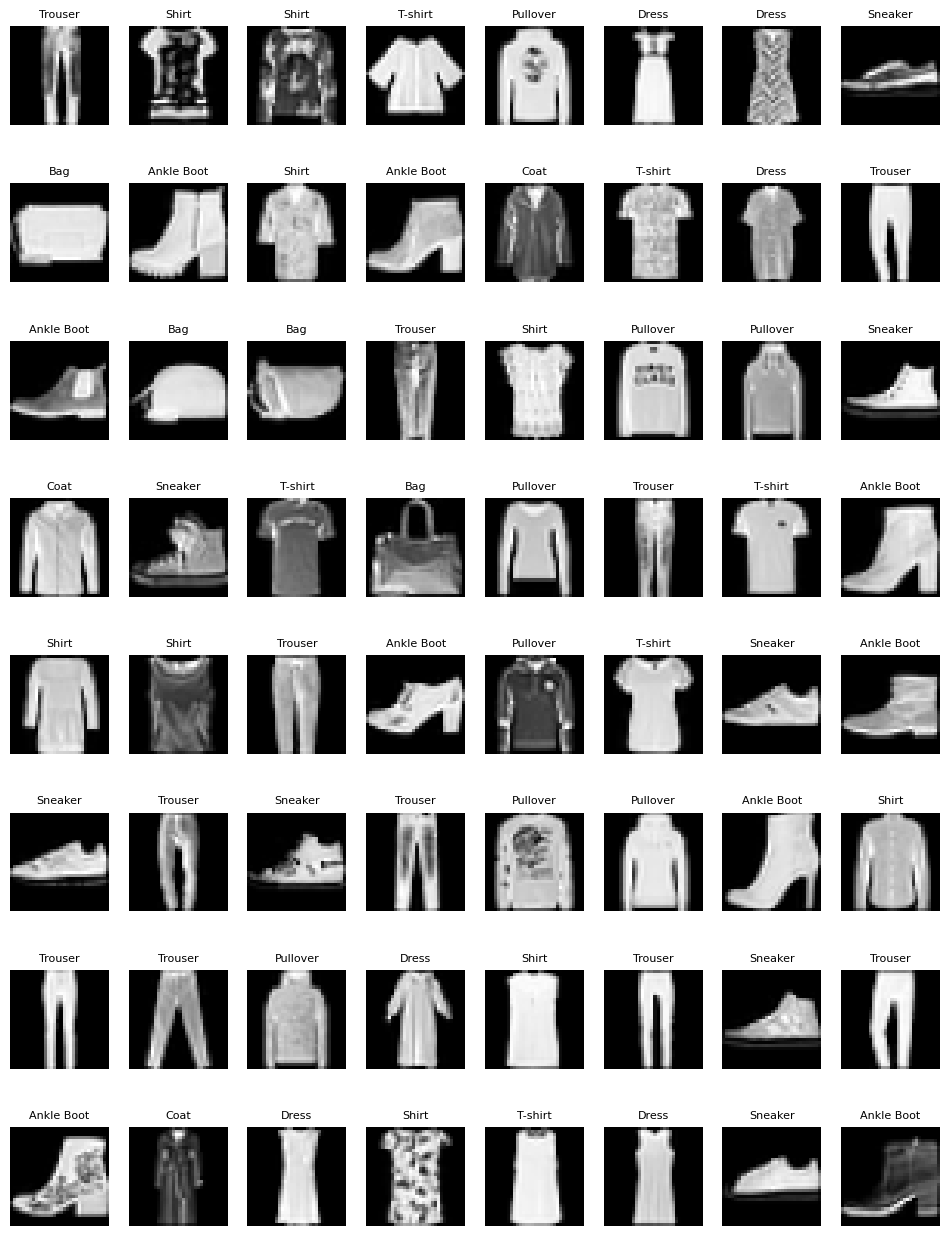

In [38]:
def visualize_data():
    nrows = 8
    ncols = 8
    indices = np.random.randint(low=0, high=60000, size=nrows*ncols).reshape(nrows,ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(12,16))
    for i in range(nrows):
        for j in range(ncols):
            idx = indices[i][j]
            img = train_dataset[idx][0]
            img = img/2 + 0.5   # unnormalize (makes the image better looking)
            npimg = img.numpy()
            npimg = np.transpose(npimg, (1,2,0))
            label = classes[train_dataset[idx][1]]
            ax[i,j].imshow(npimg, cmap="gray")
            ax[i,j].set_title(label, fontsize=8)
            ax[i,j].axis("off")


visualize_data()

In [39]:
def get_single_img():
    """
    Returns a single image as a numpy array.
    """
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    img = images[0]
    img = img/2 + 0.5   # unnormalize (makes the image better looking)
    return img

get_single_img().shape

torch.Size([1, 32, 32])

In [40]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


In [41]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3),
                               stride=2, padding=(1,1))
        self.lin1 = nn.Linear(2048, 1024)    # to get the value 2048, just check the shape of x after torch.flatten
        self.lin2 = nn.Linear(1024, 512)
        self.lin3 = nn.Linear(512, 128)
        self.dropout1 = nn.Dropout2d(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.bnorm1 = nn.BatchNorm2d(32)
        self.bnorm2 = nn.BatchNorm2d(128)
        self.bnorm3 = nn.BatchNorm1d(1024)
        self.bnorm4 = nn.BatchNorm1d(128)
        self.mu = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.logvar = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        x = self.bnorm1(F.relu(self.conv1(x)))
        x = self.dropout1(F.relu(self.conv2(x)))
        x = self.bnorm2(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)   # flatten all dimensions except batch
        x = self.bnorm3(F.relu(self.lin1(x)))
        x = self.dropout2(F.relu(self.lin2(x)))
        x = self.bnorm4(F.relu(self.lin3(x)))
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar


In [42]:
summary(model=Encoder(32), input_size=(1,1,32,32), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Encoder (Encoder)                        [1, 1, 32, 32]       [1, 32]              --                   True
├─Conv2d (conv1)                         [1, 1, 32, 32]       [1, 32, 16, 16]      320                  True
├─BatchNorm2d (bnorm1)                   [1, 32, 16, 16]      [1, 32, 16, 16]      64                   True
├─Conv2d (conv2)                         [1, 32, 16, 16]      [1, 64, 8, 8]        18,496               True
├─Dropout2d (dropout1)                   [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
├─Conv2d (conv3)                         [1, 64, 8, 8]        [1, 128, 4, 4]       73,856               True
├─BatchNorm2d (bnorm2)                   [1, 128, 4, 4]       [1, 128, 4, 4]       256                  True
├─Linear (lin1)                          [1, 2048]            [1, 1024]            2,098,176            True
├─BatchNorm1d (b

In [43]:
def fn():
    model = Encoder(32).to(device)
    for X,y in train_loader:
        X = X.to(device)
        y = y.to(device)
        print(X.shape)
        print(y.shape)
        mu, logvar = model(X)
        print(mu.shape, logvar.shape, sep='\n')
        break
    

fn()

torch.Size([128, 1, 32, 32])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])


In [44]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


In [55]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(latent_dim, 128)
        self.lin2 = nn.Linear(128, 2048)
        self.convt1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, 
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.convt2 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                                         kernel_size=(3,3), stride=2, padding=(1,1),
                                         output_padding=(1,1))
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3,3),
                               stride=1, padding="same")
        self.dropout = nn.Dropout2d(p=0.3)
        self.bnorm1 = nn.BatchNorm1d(128)
        self.bnorm2 = nn.BatchNorm2d(128)
        self.bnorm3 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.bnorm1(F.relu(self.lin1(x)))
        x = F.relu(self.lin2(x))
        x = x.view(-1, 128, 4, 4)     # we get 4 after dividing 2048 by (128 * batch_size * 2)
        x = self.bnorm2(F.relu(self.convt1(x)))        
        x = self.dropout(F.relu(self.convt2(x)))
        x = self.bnorm3(F.relu(self.convt3(x)))
        x = F.sigmoid(self.conv1(x))
        return x
        

In [56]:
summary(model=Decoder(32), input_size=(1,32), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Decoder (Decoder)                        [1, 32]              [1, 1, 32, 32]       --                   True
├─Linear (lin1)                          [1, 32]              [1, 128]             4,224                True
├─BatchNorm1d (bnorm1)                   [1, 128]             [1, 128]             256                  True
├─Linear (lin2)                          [1, 128]             [1, 2048]            264,192              True
├─ConvTranspose2d (convt1)               [1, 128, 4, 4]       [1, 128, 8, 8]       147,584              True
├─BatchNorm2d (bnorm2)                   [1, 128, 8, 8]       [1, 128, 8, 8]       256                  True
├─ConvTranspose2d (convt2)               [1, 128, 8, 8]       [1, 64, 16, 16]      73,792               True
├─Dropout2d (dropout)                    [1, 64, 16, 16]      [1, 64, 16, 16]      --                   --
├─ConvTranspose2

In [57]:
def fn():
    latent_dim = 32
    encoder = Encoder(latent_dim).to(device)
    decoder = Decoder(latent_dim).to(device)
    for X,y in train_loader:
        X = X.to(device)
        y = y.to(device)
        mu, logvar = encoder(X)
        print("mu.shape:\t\t", mu.shape)
        print("logvar.shape:\t\t", logvar.shape)
        sigma = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(sigma)
        z = mu + logvar*epsilon
        dec_output = decoder(z)
        print("dec_output.shape:\t", dec_output.shape)
        break


fn()

mu.shape:		 torch.Size([128, 32])
logvar.shape:		 torch.Size([128, 32])
dec_output.shape:	 torch.Size([128, 1, 32, 32])


In [58]:
# use this code to free up gpu memory
gc.collect()
torch.cuda.empty_cache()
print("freed up some memory!")

freed up some memory!


Workflow of VAE:

- Input is image $x$
- $\mu, \, \log_e \sigma^2 \; = \; \text{Encoder}(x)$
- $z = \mu + \sigma \cdot \varepsilon$, where $\varepsilon \in \mathcal{N}(0,1) \qquad \rightarrow \quad \text{reparameterization trick}$
- $\text{Generated image} \; = \; \text{Decoder}(z)$

\begin{align*}
\text{log}_e \, \sigma^2 & \; = \; \text{logvar} \\
\sigma^2 & \; = \; e^{\text{logvar}} \\
\sigma & \; = \; \sqrt{e^{\text{logvar}}} \\ \\
\therefore \;\; \sigma & \; = \; e^{0.5 \times \text{logvar}} \\ 
\end{align*}

In [59]:
class Variational_Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(Variational_Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)   # standard deviation
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        return z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        output = self.decoder(z)
        return output
        

In [60]:
summary(model=Variational_Autoencoder(32), input_size=(1,1,32,32), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
Variational_Autoencoder (Variational_Autoencoder)  [1, 1, 32, 32]       [1, 1, 32, 32]       --                   True
├─Encoder (encoder)                                [1, 1, 32, 32]       [1, 32]              --                   True
│    └─Conv2d (conv1)                              [1, 1, 32, 32]       [1, 32, 16, 16]      320                  True
│    └─BatchNorm2d (bnorm1)                        [1, 32, 16, 16]      [1, 32, 16, 16]      64                   True
│    └─Conv2d (conv2)                              [1, 32, 16, 16]      [1, 64, 8, 8]        18,496               True
│    └─Dropout2d (dropout1)                        [1, 64, 8, 8]        [1, 64, 8, 8]        --                   --
│    └─Conv2d (conv3)                              [1, 64, 8, 8]        [1, 128, 4, 4]       73,856               True
│    └─BatchNorm2d (bnorm2)                  

In [62]:
def fn():
    latent_dim = 32
    vae = Variational_Autoencoder(latent_dim).to(device)
    for X,y in train_loader:
        X = X.to(device)
        y = y.to(device)
        output = vae(X)
        print("output.shape:\t", output.shape)
        break


fn()

output.shape:	 torch.Size([128, 1, 32, 32])
